# Error Analysis: ResNet50 + SVC
## Phân tích lỗi dự đoán trên 3 lớp: Shark, Shrimp, Squid

Notebook này sử dụng các model đã train:
- Feature Extractor: `resnet50_feature_extractor.h5`
- Scaler: `scaler_resnet_feature_extraction.pkl`
- Classifier: `svc_model_tuned.pkl`

Mục tiêu: Tìm 3 ảnh đúng và 3 ảnh sai cho mỗi lớp.

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib
import pickle
from tensorflow.keras.applications.resnet50 import preprocess_input

# Cấu hình hiển thị
%matplotlib inline

# Đường dẫn
BASE_DIR = os.path.dirname(os.path.abspath("__file__")) # Thư mục hiện tại (demo)
PROJECT_DIR = os.path.join(BASE_DIR, '..', 'project')
TEST_DIR = os.path.join(PROJECT_DIR, 'split_data', 'test')

# Load models
print("Loading models...")
resnet_model = tf.keras.models.load_model('resnet50_feature_extractor.h5')
scaler = joblib.load('scaler_resnet_feature_extraction.pkl')
svc_model = joblib.load('svc_model_tuned.pkl')
print("Models loaded successfully.")

# Lấy danh sách class (để map index -> tên class)
# Giả sử model được train với thứ tự class theo alphabet trong thư mục data
all_classes = sorted(os.listdir(TEST_DIR))
class_to_idx = {cls_name: idx for idx, cls_name in enumerate(all_classes)}
idx_to_class = {idx: cls_name for idx, cls_name in enumerate(all_classes)}

print(f"Total classes: {len(all_classes)}")
print(f"Target classes: Sharks, Shrimp, Squid")

Loading models...


Models loaded successfully.
Total classes: 23
Target classes: Sharks, Shrimp, Squid


g:\miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
g:\miniconda3\envs\tf_env\lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator SVC from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [2]:
def get_prediction(img_path, resnet_model, scaler, svc_model):
    # 1. Read and Resize
    img = cv2.imread(img_path)
    if img is None:
        return None, None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    
    # 2. Preprocess for ResNet50
    img_preprocessed = preprocess_input(img_resized.astype('float32'))
    img_batch = np.expand_dims(img_preprocessed, axis=0)
    
    # 3. Extract Features
    features = resnet_model.predict(img_batch, verbose=0)
    features_flatten = features.reshape(1, -1)
    
    # 4. Scale
    features_scaled = scaler.transform(features_flatten)
    
    # 5. Predict
    pred_idx = svc_model.predict(features_scaled)[0]
    
    return pred_idx, img

target_classes = ['Sharks', 'Shrimp', 'Squid']
results = {cls: {'correct': [], 'incorrect': []} for cls in target_classes}

for target_cls in target_classes:
    print(f"Processing class: {target_cls}...")
    cls_dir = os.path.join(TEST_DIR, target_cls)
    if not os.path.exists(cls_dir):
        print(f"Directory not found: {cls_dir}")
        continue
        
    true_idx = class_to_idx[target_cls]
    image_files = [f for f in os.listdir(cls_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Shuffle để lấy ngẫu nhiên nếu muốn, hoặc lấy tuần tự
    # np.random.shuffle(image_files) 
    
    for img_file in image_files:
        # Stop if we have enough samples for this class
        if len(results[target_cls]['correct']) >= 3 and len(results[target_cls]['incorrect']) >= 3:
            break
            
        img_path = os.path.join(cls_dir, img_file)
        pred_idx, img = get_prediction(img_path, resnet_model, scaler, svc_model)
        
        if pred_idx is None:
            continue
            
        pred_cls = idx_to_class[pred_idx]
        
        item = {
            'image': img,
            'filename': img_file,
            'true_class': target_cls,
            'pred_class': pred_cls
        }
        
        if pred_idx == true_idx:
            if len(results[target_cls]['correct']) < 3:
                results[target_cls]['correct'].append(item)
        else:
            if len(results[target_cls]['incorrect']) < 3:
                results[target_cls]['incorrect'].append(item)

    print(f"  Found {len(results[target_cls]['correct'])} correct, {len(results[target_cls]['incorrect'])} incorrect.")


Processing class: Sharks...
  Found 3 correct, 3 incorrect.
Processing class: Shrimp...
  Found 3 correct, 3 incorrect.
Processing class: Shrimp...
  Found 3 correct, 3 incorrect.
Processing class: Squid...
  Found 3 correct, 3 incorrect.
Processing class: Squid...
  Found 3 correct, 3 incorrect.
  Found 3 correct, 3 incorrect.



==================== CLASS: Sharks ====================


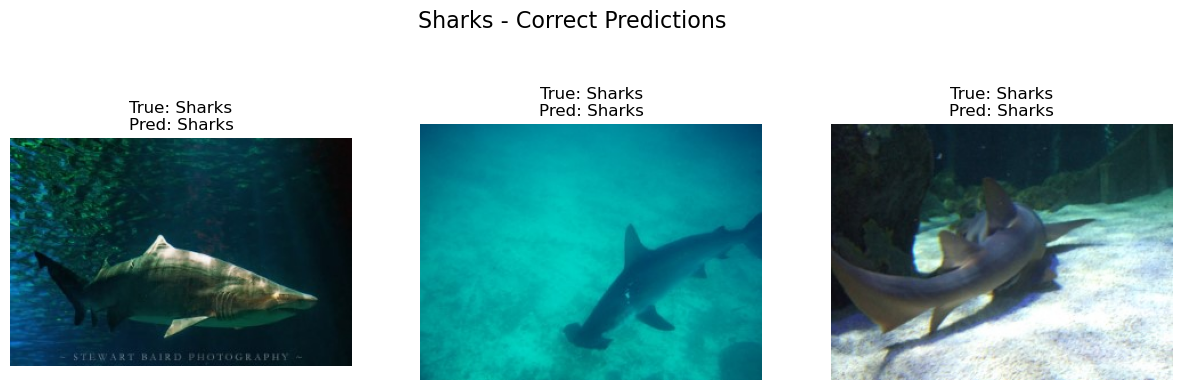

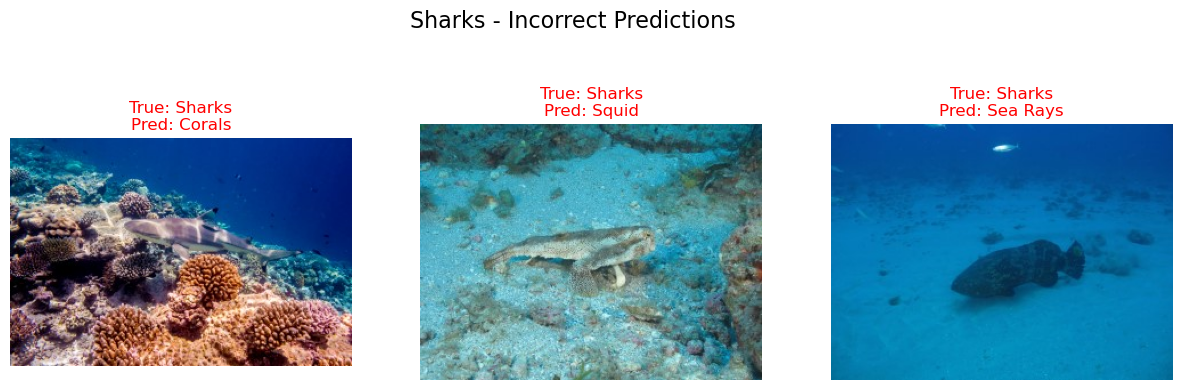


==================== CLASS: Shrimp ====================


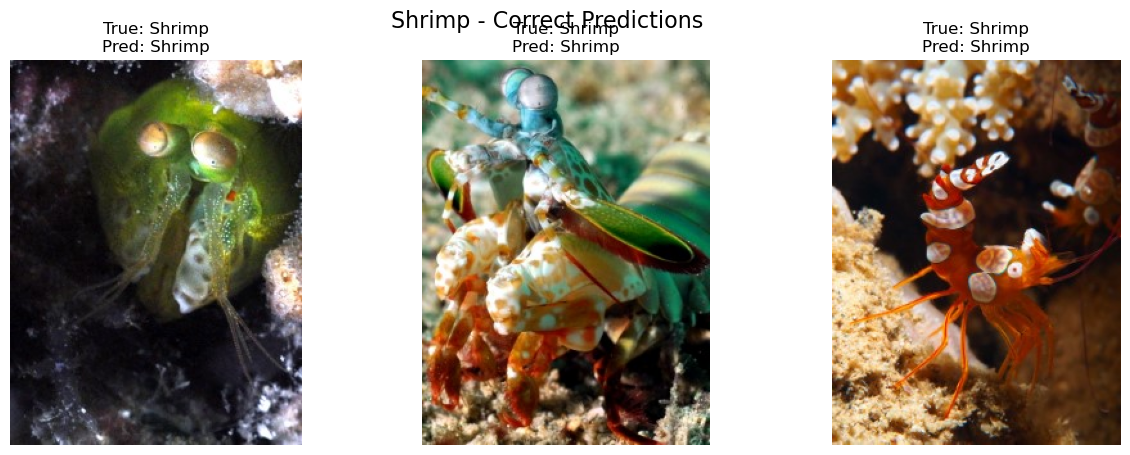

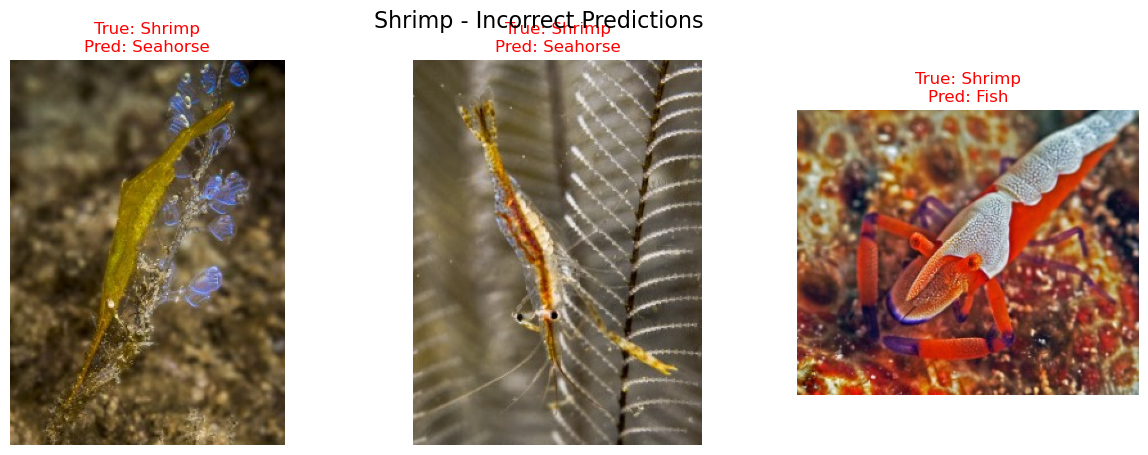


==================== CLASS: Squid ====================


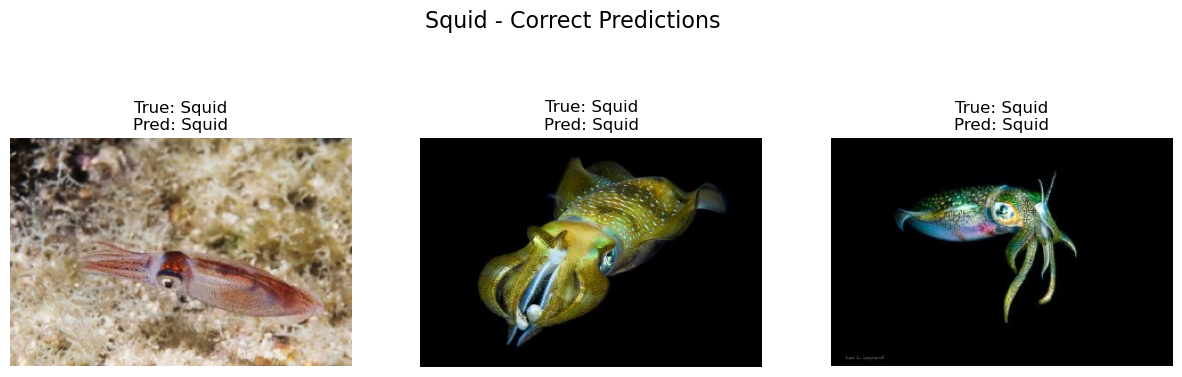

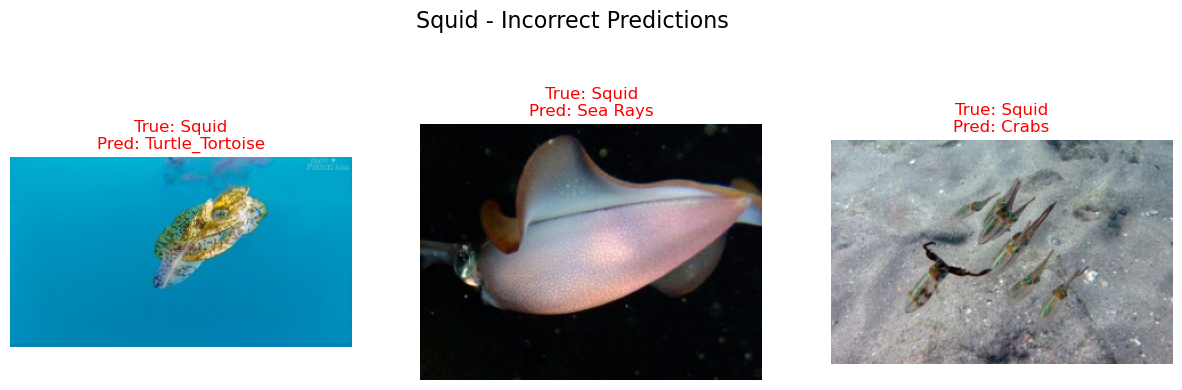

In [3]:
def visualize_results(results, target_classes):
    for cls in target_classes:
        print(f"\n{'='*20} CLASS: {cls} {'='*20}")
        
        # Correct predictions
        correct_samples = results[cls]['correct']
        if correct_samples:
            plt.figure(figsize=(15, 5))
            plt.suptitle(f"{cls} - Correct Predictions", fontsize=16)
            for i, item in enumerate(correct_samples):
                plt.subplot(1, 3, i+1)
                plt.imshow(item['image'])
                plt.title(f"True: {item['true_class']}\nPred: {item['pred_class']}")
                plt.axis('off')
            plt.show()
        else:
            print(f"No correct predictions found for {cls}")

        # Incorrect predictions
        incorrect_samples = results[cls]['incorrect']
        if incorrect_samples:
            plt.figure(figsize=(15, 5))
            plt.suptitle(f"{cls} - Incorrect Predictions", fontsize=16)
            for i, item in enumerate(incorrect_samples):
                plt.subplot(1, 3, i+1)
                plt.imshow(item['image'])
                plt.title(f"True: {item['true_class']}\nPred: {item['pred_class']}", color='red')
                plt.axis('off')
            plt.show()
        else:
            print(f"No incorrect predictions found for {cls}")

visualize_results(results, target_classes)